In [ ]:
import numpy as np
import pandas as pd
import math
import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot, plot
import plotly.express as px
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

from warnings import simplefilter
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(12, 6),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

import random
import os

SEED = 2021
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(SEED)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LarsCV
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import NearestCentroid

from sklearn.linear_model import QuantileRegressor
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Perceptron
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder

from scipy.stats.mstats import gmean, hmean
from numpy import mean, median

#  My other notebooks :
* [Basic EDA with visualization  and animated polar plot](https://www.kaggle.com/code/martynovandrey/tps-mar-22-step-0-data-exploration-animation) 
* [Looking for special values, EDA](https://www.kaggle.com/code/martynovandrey/tps-mar-22-step-0-1-special-values)
* [Features selection](https://www.kaggle.com/code/martynovandrey/tps-mar-22-fe-the-less-the-better)
* [MultiOutput regressor, 65 targets in one](https://www.kaggle.com/code/martynovandrey/tps-mar-22-multioutput-cat-modeless)
* [Hybrid regressor, two step model](https://www.kaggle.com/code/martynovandrey/tps-mar-22-hybrid-regressors)
* [Multimodel regression, blendig, postprocessing - my best public score so far](https://www.kaggle.com/code/martynovandrey/tps-mar-22-fe-model-selection)
* [How to use special values to improve submission, dataset shared](https://www.kaggle.com/code/martynovandrey/tps-mar-22-don-t-forget-special-values)

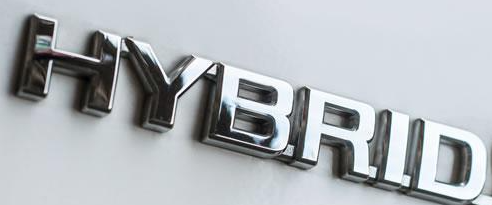  

* Based on [Hybrid Models](https://www.kaggle.com/ryanholbrook/hybrid-models)

# Read data

In [ ]:
df_train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', index_col="row_id", parse_dates=['time'])
df_test = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv', index_col="row_id", parse_dates=['time'])
df_train_idx = df_train.index
df_test_idx = df_test.index

### x, y, direction -> road

In [ ]:
df_train['road'] = df_train['x'].astype(str) + df_train['y'].astype(str) + df_train['direction']
df_test['road']  = df_test['x'].astype(str) + df_test['y'].astype(str) + df_test['direction']

le = LabelEncoder()
df_train['road'] = le.fit_transform(df_train['road'])
df_test['road']  = le.transform(df_test['road'])

df_train = df_train.drop(['x', 'y', 'direction'], axis=1)
df_test = df_test.drop(['x', 'y', 'direction'], axis=1)

# Feature Engineering

### Date and time features

In [ ]:
def add_datetime_features(df):
    df['month']   = df['time'].dt.month
    df['day']     = df['time'].dt.day
    df['weekday'] = df['time'].dt.weekday
    df['weekend'] = (df['time'].dt.weekday >= 5)
    df['hour']    = df['time'].dt.hour
    df['minute']  = df['time'].dt.minute
    df['afternoon'] = df['hour'] >= 12
    
    # number of 20' period in a day
    df['moment']  = df['time'].dt.hour * 3 + df['time'].dt.minute // 20 
    
add_datetime_features(df_train)
add_datetime_features(df_test)    

### Split train and test for 1st and 2nd regressors

In [ ]:
df_train2 = df_train.copy()
df_test2 = df_test.copy()

### Congestion Morning average, Min, Max, Median, Quantiles features

In [ ]:
df_mornings = df_train[(df_train.hour >= 6) & (df_train.hour < 12)]
morning_avgs = pd.DataFrame(df_mornings.groupby(['month', 'day', 'road']).congestion.median().astype(int)).reset_index()
morning_avgs = morning_avgs.rename(columns={'congestion':'morning_avg'})
df_train = df_train.merge(morning_avgs, on=['month', 'day', 'road'], how='left')
df_test = df_test.merge(morning_avgs, on=['month', 'day', 'road'], how='left')
df_train2 = df_train2.merge(morning_avgs, on=['month', 'day', 'road'], how='left')
df_test2 = df_test2.merge(morning_avgs, on=['month', 'day', 'road'], how='left')

mins = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.min().astype(int)).reset_index()
mins = mins.rename(columns={'congestion':'min'})
df_train = df_train.merge(mins, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(mins, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_train2 = df_train2.merge(mins, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test2 = df_test2.merge(mins, on=['road', 'weekday', 'hour', 'minute'], how='left')

maxs = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.max().astype(int)).reset_index()
maxs = maxs.rename(columns={'congestion':'max'})
df_train = df_train.merge(maxs, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(maxs, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_train2 = df_train2.merge(maxs, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test2 = df_test2.merge(maxs, on=['road', 'weekday', 'hour', 'minute'], how='left')

medians = pd.DataFrame(df_train.groupby(['road', 'weekday', 'hour', 'minute']).congestion.median().astype(int)).reset_index()
medians = medians.rename(columns={'congestion':'median'})
df_train = df_train.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test = df_test.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_train2 = df_train2.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')
df_test2 = df_test2.merge(medians, on=['road', 'weekday', 'hour', 'minute'], how='left')

### PCA

In [ ]:
important_features = ['moment', 'median', 'min', 'max', 'morning_avg']

X = df_train.copy()
X_t = df_test.copy()

y = X.pop('congestion')
X = X.loc[:, important_features]
X_t = X_t.loc[:, important_features]

from sklearn.decomposition import PCA

# Create principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_t_pca = pca.transform(X_t)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
X_t_pca = pd.DataFrame(X_t_pca, columns=component_names)

df_train = pd.concat([df_train, X_pca], axis=1)
df_test = pd.concat([df_test, X_t_pca], axis=1)

X = df_train2.copy()
X_t = df_test2.copy()

y = X.pop('congestion')
X = X.loc[:, important_features]
X_t = X_t.loc[:, important_features]

# Create principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_t_pca = pca.transform(X_t)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
X_t_pca = pd.DataFrame(X_t_pca, columns=component_names)

df_train2 = pd.concat([df_train2, X_pca], axis=1)
df_test2 = pd.concat([df_test2, X_t_pca], axis=1)

# Drop unimportant features
* Feature selection is in the [TPS Mar 22, FE, the less the better](https://www.kaggle.com/martynovandrey/tps-mar-22-fe-the-less-the-better) notebook. I used mutual information, permutation importances and SHAP to find features to remove, the score improved by 0.023

In [ ]:
df_train = df_train.drop(['month', 'day', 'weekday', 'weekend', 'hour', 'minute', 'afternoon'], axis=1)
df_test = df_test.drop(['month', 'day', 'weekday', 'weekend', 'hour', 'minute', 'afternoon'], axis=1)
df_train2 = df_train2.drop(['month', 'day', 'weekday', 'weekend', 'hour', 'minute', 'afternoon'], axis=1)
df_test2 = df_test2.drop(['month', 'day', 'weekday', 'weekend', 'hour', 'minute', 'afternoon'], axis=1)

## SPLIT df_train -> valid_train, valid_test

In [ ]:
tst_start = pd.to_datetime('1991-09-23 12:00')
tst_finish = pd.to_datetime('1991-09-23 23:40')

valid_test = df_train[(df_train['time'] >= tst_start) & (df_train['time'] <= tst_finish)]
valid_test2 = df_train2[(df_train2['time'] >= tst_start) & (df_train2['time'] <= tst_finish)]

valid_target = valid_test.pop('congestion')
valid_sample_submission = valid_test.copy()
valid_sample_submission['congestion'] = 50
valid_sample_submission = valid_sample_submission['congestion'] 

valid_train = df_train[df_train['time'] < tst_start]
valid_train2 = df_train2[df_train2['time'] < tst_start]

X_train = valid_train.copy()
X_train = X_train.drop(['time'], axis=1)
y_train = X_train['congestion']
X_train = X_train.drop(['congestion'], axis=1)
X_test = valid_test.drop(['time'], axis=1)

X_train2 = valid_train2.copy()
X_train2 = X_train2.drop(['time'], axis=1)
y_train2 = X_train2['congestion']
X_train2 = X_train2.drop(['congestion'], axis=1)
X_test2 = valid_test2.drop(['time', 'congestion'], axis=1)

# MedianRegressor

In [ ]:
class MedianRegressor():
    def __init__(self):
        self.medians = None
        
    def fit(self, X, y):
        df = X.copy()
        df['target'] = y
        self.medians = df.groupby(['road', 'moment']).target.median()
        self.medians = self.medians - 0.000001
        self.medians = self.medians.round().astype(int)

    def predict(self, X):
        sub = X.merge(self.medians, left_on=['road', 'moment'], right_index=True)[['target']]
        return sub['target']
    
    def get_params(self, deep=True):
        return dict()

In [ ]:
class ZeroRegressor():
    # For use as second regressor, does nothing, i.e. returns zero
    def __init__(self):
        pass
        
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        df = X.copy()
        df['target'] = 0
        return df['target']
    
    def get_params(self, deep=True):
        return dict()

### Function to compare 1st regressors  

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate

ts_cv = TimeSeriesSplit(n_splits=15, test_size=65*36)

def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    return mae

def compareCV(regressors, X, y, cv):
    scores = []
    for rgr in regressors:
        print(rgr['name'].ljust(10), end=' ')
        model = rgr['model']
        mae = evaluate(model, X, y, cv=ts_cv)
        print(rgr['description'].rjust(30), f' mae: {mae.mean():.3f} +/- {mae.std():.3f}')
        for i in range(len(mae)):
            item = {}
            item['regressor'] = rgr['name']
            item['mae'] = mae[i]
            scores.append(item)
    df_scores = pd.DataFrame(scores)
    fig, ax = plt.subplots(figsize=(16, 4))
    sns.boxplot(data=df_scores, x='regressor', y='mae', ax=ax)
    ax.set_ylim(bottom=4.8)
    
    return scores

In [ ]:
def compare(regressors, X_train, y_train, X_test, sample_submission, valid_target=[]):
    subs = pd.DataFrame()
    for rgr in regressors:
        print(rgr['name'], end=' ')
        model = rgr['model']
        model.fit(X_train, y_train)
        prediction = pd.Series(model.predict(X_test))
       
        sub = pd.DataFrame(sample_submission)
        prediction.index = sub.index
        sub['congestion'] = prediction
        sub['congestion'] = sub['congestion'].apply(lambda x: round(x))
        subs = pd.concat([subs, sub.rename(columns={'congestion':rgr['name']})], axis=1)
        if len(valid_target) > 0:
            sub_target = sub['congestion']
            mae = mean_absolute_error(valid_target, sub_target)
            rgr['score'] = mae
            print(rgr['description'].rjust(30), f'mae = {mae:.3f}\n')  

    subs['congestion'] = subs.mean(axis=1).apply(lambda x: round(x))
    df_regressors = pd.DataFrame(regressors)
    
    if len(valid_target) > 0:
        sub_target = subs['congestion']
        mae = mean_absolute_error(valid_target, sub_target)
        print('BLENDED'.rjust(30), f'test = {mae:.3f}\n')
        fig, ax = plt.subplots(figsize=(16, 6))
        sns.barplot(data=df_regressors, x='name', y='score', ax=ax)
        ax.set_ylim(bottom=4.8)    
    return df_regressors, subs

# Compare 1st Regressors

In [ ]:
cat0 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=42)
cat1 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=77)
cat2 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=2022)
cat3 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=188)
cat4 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=500)
cat5 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=17)
cat6 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=3)
estimators=[('cat0', cat0), ('cat1', cat1), ('cat2', cat2), ('cat3', cat3), ('cat4', cat4), ('cat5', cat5), ('cat6', cat6)]

regressors = []
# regressors.append({'name': 'MLP',     'model': MLPRegressor(random_state=1, max_iter=500, hidden_layer_sizes=(65, 65, 65)),                                        'description': 'MLPRegressor'})
regressors.append({'name': 'Median',  'model': MedianRegressor(),                                                                 'description': 'MedianRegressor'})
regressors.append({'name': 'BRidge',  'model': BayesianRidge(),         'description': 'BayesianRidge'})
regressors.append({'name': 'HGBR',    'model': HistGradientBoostingRegressor(max_iter=10875, learning_rate=0.0307, max_leaf_nodes=176, max_depth=18, min_samples_leaf=49, loss='absolute_error'),                'description': 'HistGradientBoostingRegressor'})
# regressors.append({'name': 'GBR',     'model': GradientBoostingRegressor(n_estimators=300, loss='absolute_error'),                'description': 'GradientBoostingRegressor'})
regressors.append({'name': 'CAT',     'model': CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE'),  'description': 'CatBoostRegressor'})
regressors.append({'name': 'LGBM',    'model': LGBMRegressor(metric='mae'),                                                       'description': 'LGBMRegressor'})
regressors.append({'name': 'VOT',     'model': VotingRegressor(estimators=estimators, verbose=True),                               'description': 'VotingRegressor'})

# df_regressors, subs = compare(regressors, X_train, y_train, X_test, valid_sample_submission, valid_target)

In [ ]:
regressors = []
regressors.append({'name': 'Linear',  'model': LinearRegression(),                           'description': 'LinearRegression'})
regressors.append({'name': 'Ridge',   'model': Ridge(),                                      'description': 'Ridge'})
regressors.append({'name': 'Lasso',   'model': Lasso(),                                      'description': 'Lasso'})
regressors.append({'name': 'ENet',    'model': ElasticNet(),                                 'description': 'ElasticNet'})
regressors.append({'name': 'LarsCV',  'model': LarsCV(),                                     'description': 'LarsCV'})
regressors.append({'name': 'BRidge',  'model': BayesianRidge(),                              'description': 'BayesianRidge'})

regressors.append({'name': 'KNR',     'model': KNeighborsRegressor(),                        'description': 'KNeighborsRegressor'})
regressors.append({'name': 'KNR25',   'model': KNeighborsRegressor(n_neighbors=25),          'description': 'KNeighborsRegressor 25'})
regressors.append({'name': 'KNR100',  'model': KNeighborsRegressor(n_neighbors=100),         'description': 'KNeighborsRegressor 100'})
regressors.append({'name': 'KNR300',  'model': KNeighborsRegressor(n_neighbors=300),         'description': 'KNeighborsRegressor 300'})

regressors.append({'name': 'HBR',    'model': HuberRegressor(),                                                              'description': 'HuberRegressor'})
regressors.append({'name': 'SGDh',   'model': SGDRegressor(loss='huber', shuffle=False, random_state=42),                    'description': 'SGDRegressor huber'})
regressors.append({'name': 'SGDe',   'model': SGDRegressor(loss='epsilon_insensitive', shuffle=False, random_state=42),      'description': 'SGDRegressor epsilon'})

# df_scores = compareCV(regressors, X, y, ts_cv)

# Hybrid regressor

In [ ]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        # for visualization
        self.y_fit   = None
        self.y_resid = None
        self.y_resid_r = None
        self.y_pred1 = None
        self.y_pred2 = None

    def fit(self, X_1, X_2, y):
        # Train model_1
        self.model_1.fit(X_1, y)
        y_fit = self.model_1.predict(X_1)
        self.y_fit = pd.DataFrame(y_fit).rename(columns={0:'y_fit'})
        
        y_resid = y - y_fit
        
        self.y_resid = pd.DataFrame(y_resid).rename(columns={0:'y_resid'})
        
        self.model_2.fit(X_2, y_resid)
       
    def predict(self, X_1, X_2):
        y_pred = self.model_1.predict(X_1)
        self.y_pred1 = pd.DataFrame(y_pred).rename(columns={0:'y_pred1'})
        self.y_pred1.index = X_1.index
        
        y_pred2 = self.model_2.predict(X_2)
        self.y_pred2 = pd.DataFrame(y_pred2).rename(columns={0:'y_pred2'})
        self.y_pred2.index = X_2.index
        
        y_pred += y_pred2
        return y_pred

# How does Hybrid Regressor work?

### Train and valid congestion
* Use data till 09-16 11:40 (-week) as train
* Use monday 09-16 afternoon for validation
* Plots show time from Sep 16 for better view

In [ ]:
# this code is for visualization only
sample_start = pd.to_datetime('1991-09-16 00:00')
valid_start  = pd.to_datetime('1991-09-23 12:00')
valid_finish = pd.to_datetime('1991-09-23 23:40')

sample = df_train[(df_train.time >= sample_start) & (df_train.time <= valid_finish)]
sample['roadway'] = le.inverse_transform(sample.road)
sample['y'] = 'train'
sample.loc[sample.time >= valid_start, 'y'] = 'valid'
fig = px.line(sample, x='time', y='congestion', color='y', animation_frame='roadway')
fig.show()

df = pd.concat([X_train[['road']], X_test[['road']]], axis=0)
df['time'] = df_train['time']
df['y_train'] = y_train
df['y_valid'] = valid_target

* Hybrid reegressor has two models, model1 and model2, and two different (or not) X, X_train and X_train2
1. model1.fit(X_train, y_train)
2. y_fit = model1.predict(X_train)
3. y_residual = y_train - y_fit
* model2 uses residual as input
4. model2.fit(X_train2, y_residual)

In [ ]:
model = BoostedHybrid(SGDRegressor(loss='huber', shuffle=False, random_state=42), CatBoostRegressor(logging_level='Silent', n_estimators=800, eval_metric='MAE', loss_function='MAE'))
model.fit(X_train, X_train, y_train)

In [ ]:
# for visualization only
df['y_fit'] = model.y_fit
df['y_resid'] = model.y_resid

sample = df[(df.time >= sample_start)]
plot_data = pd.DataFrame()
for y in sample.columns[2:]:
    tmp = sample[list(sample.columns[:2]) + [y]]
    tmp['y'] = y
    tmp = tmp.rename(columns={y:'congestion'})
    plot_data = pd.concat([plot_data, tmp], axis=0)
plot_data['roadway'] = le.inverse_transform(plot_data.road)    
fig = px.line(plot_data, x='time', y='congestion', color='y', animation_frame='roadway')
fig.show()   

5. prediction1 = model1.predict(X_test)
6. prediction2 = model2.predict(X_test2)
7. final prediction = prediction1 + prediction2

In [ ]:
prediction = model.predict(X_test, X_test)

mae = mean_absolute_error(valid_target, prediction)
rounded = prediction.round()
rmae = mean_absolute_error(valid_target, rounded)
print(f'MAE: {mae:.3f}, after rounding: {rmae:.3f}')

In [ ]:
# for visualization only
df['pred1'] = model.y_pred1
df['pred2'] = model.y_pred2
pred = pd.DataFrame(pd.Series(prediction).rename('pred'))
pred.index = X_test.index
pred_r = pd.DataFrame(pd.Series(rounded).rename('pred'))
pred_r.index = X_test.index
df['pred'] = pred['pred'] 
df['rounded'] = pred_r['pred']

sample = df[(df.time >= sample_start)]
plot_data = pd.DataFrame()
for y in sample.columns[2:]:
    tmp = sample[list(sample.columns[:2]) + [y]]
    tmp['y'] = y
    tmp = tmp.rename(columns={y:'congestion'})
    plot_data = pd.concat([plot_data, tmp], axis=0)
plot_data['roadway'] = le.inverse_transform(plot_data.road)    
fig = px.line(plot_data, x='time', y='congestion', color='y', animation_frame='roadway')
fig.show() 

### The same with different models

In [ ]:
model = BoostedHybrid(MedianRegressor(), HistGradientBoostingRegressor(max_iter=300, loss='absolute_error')) 
model.fit(X_train, X_train2, y_train)
prediction = model.predict(X_test, X_test2)

mae = mean_absolute_error(valid_target, prediction)
rounded = prediction.round()
rmae = mean_absolute_error(valid_target, rounded)
print(f'MAE: {mae:.3f}, after rounding: {rmae:.3f}')

In [ ]:
# df is for visualization
df = pd.concat([X_train[['road']], X_test[['road']]], axis=0)
df['time'] = df_train['time']
df['y_train'] = y_train
df['y_valid'] = valid_target
df['y_fit'] = model.y_fit
df['y_resid'] = model.y_resid
df['pred1'] = model.y_pred1
df['pred2'] = model.y_pred2
pred = pd.DataFrame(pd.Series(prediction).rename('pred'))
pred.index = X_test.index
pred_r = pd.DataFrame(pd.Series(rounded).rename('pred'))
pred_r.index = X_test.index
df['pred'] = pred['pred'] 
df['rounded'] = pred_r['pred']

sample = df[(df.time >= sample_start)]
plot_data = pd.DataFrame()
for y in sample.columns[2:]:
    tmp = sample[list(sample.columns[:2]) + [y]]
    tmp['y'] = y
    tmp = tmp.rename(columns={y:'congestion'})
    plot_data = pd.concat([plot_data, tmp], axis=0)
plot_data['roadway'] = le.inverse_transform(plot_data.road)    
fig = px.line(plot_data, x='time', y='congestion', color='y', animation_frame='roadway')
fig.show() 

# Compare hybrid regressors

### Function to compare hybrid regressors

In [ ]:
def compare_hybrid(regressors1, regressors2, X_train1, X_train2, y_train, X_test1, X_test2, sample_submission, valid_target=[]):
    scores = {}
    subs = pd.DataFrame()
    for rgr1 in regressors1:
        for rgr2 in regressors2:
            name = rgr1['name'] + '_' + rgr2['name']
            print(name.ljust(13), end=' ')
            model = BoostedHybrid(rgr1['model'], rgr2['model'])
            model.fit(X_train1, X_train2, y_train)
            prediction = pd.Series(model.predict(X_test1, X_test2))

            sub = pd.DataFrame(sample_submission)
            prediction.index = sub.index
            sub['congestion'] = prediction
            sub['congestion'] = sub['congestion'].apply(lambda x: round(x))
            subs = pd.concat([subs, sub.rename(columns={'congestion':name})], axis=1)
            if len(valid_target) > 0:
                sub_target = sub['congestion']
                mae = mean_absolute_error(valid_target, sub_target)
                scores[name] = mae
                print((rgr1['description'] + ', ' + rgr2['description']).rjust(50), f'mae = {mae:.3f}')  

    subs['congestion'] = subs.median(axis=1).apply(lambda x: round(x))
   
    if len(valid_target) > 0:
        sub_target = subs['congestion']
        mae = mean_absolute_error(valid_target, sub_target)
        print('BLENDED'.rjust(50), f'test = {mae:.3f}\n')
    
    return scores, subs

In [ ]:
regressors1 = []
regressors1.append({'name': 'Median',  'model': MedianRegressor(),                                                                 'description': 'MedianRegressor'})
regressors1.append({'name': 'BRidge',  'model': BayesianRidge(),         'description': 'BayesianRidge'})
regressors1.append({'name': 'HGBR',    'model': HistGradientBoostingRegressor(max_iter=10875, learning_rate=0.0307, max_leaf_nodes=176, max_depth=18, min_samples_leaf=49, loss='absolute_error'),                'description': 'HistGradientBoostingRegressor'})
# regressors1.append({'name': 'GBR',     'model': GradientBoostingRegressor(n_estimators=300, loss='absolute_error'),                'description': 'GradientBoostingRegressor'})
regressors1.append({'name': 'CAT',     'model': CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE'),  'description': 'CatBoostRegressor'})
regressors1.append({'name': 'LGBM',    'model': LGBMRegressor(metric='mae'),                                                       'description': 'LGBMRegressor'})


In [ ]:
regressors2 = []
regressors2.append({'name': 'ZERO',  'model': ZeroRegressor(), 'description': 'ZeroRegressor'})
regressors2.append({'name': 'CAT',   'model': CatBoostRegressor(logging_level='Silent', n_estimators=800, eval_metric='MAE', loss_function='MAE'),  'description': 'CatBoostRegressor'})
regressors2.append({'name': 'LGBM',  'model': LGBMRegressor(n_estimators=3900, metric='mae'),                     'description': 'LGBMRegressor'})

In [ ]:
scores, subs = compare_hybrid(regressors1, regressors2, X_train, X_train, y_train, X_test, X_test, valid_sample_submission, valid_target=valid_target)

In [ ]:
matrix = []
for key in scores:
    item = {}
    item['first'] = key.split('_')[0]    
    item['second'] = key.split('_')[1]
    item['mae'] = scores[key]
    matrix.append(item)
dfm = pd.DataFrame(matrix).pivot(index='first', columns='second', values='mae')    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
sns.heatmap(dfm, annot=True, fmt='.4g', cmap=sns.color_palette("rocket_r", as_cmap=True), ax=ax)    

# SUBMISSION

In [ ]:
def make_subs_hybrid(regressors, X_train1, X_train2, y_train, X_test1, X_test2, sample_submission):
    subs = pd.DataFrame()
    for rgr in regressors:
        print(rgr['name'], end=' ')
        model = rgr['model']
        if rgr['mode'] == 'hybrid':
            model.fit(X_train1, X_train2, y_train)
            prediction = pd.Series(model.predict(X_test1, X_test2))
        else:
            model.fit(X_train1, y_train)
            prediction = pd.Series(model.predict(X_test1))
       
        sub = pd.DataFrame(sample_submission)
        prediction.index = sub.index
        sub['congestion'] = prediction
        sub['congestion'] = sub['congestion'].apply(lambda x: round(x))
        subs = pd.concat([subs, sub.rename(columns={'congestion':rgr['name']})], axis=1)
    subs['congestion'] = subs.mean(axis=1).apply(lambda x: round(x))
    return subs

### Select regressors for submission

In [ ]:
cat0 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=42, n_estimators=800)
cat1 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=77, n_estimators=800)
cat2 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=2022, n_estimators=800)
cat3 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=188, n_estimators=800)
cat4 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=500, n_estimators=800)
cat5 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=17, n_estimators=800)
cat6 = CatBoostRegressor(logging_level='Silent', eval_metric='MAE', loss_function='MAE', random_state=3, n_estimators=800)
estimators=[('cat0', cat0), ('cat1', cat1), ('cat2', cat2), ('cat3', cat3), ('cat4', cat4), ('cat5', cat5), ('cat6', cat6)]

hybrid_regressors = []
hybrid_regressors.append({'name': 'MDN_H',  'mode':'single', 'model': MedianRegressor(), 'description': 'Median Regressor'})
hybrid_regressors.append({'name': 'GBR_H',  'mode':'hybrid', 'model':BoostedHybrid(GradientBoostingRegressor(n_estimators=200, loss='absolute_error'), ZeroRegressor()), 'description':'Hybrid GBR'})
hybrid_regressors.append({'name': 'CAT_H',  'mode':'hybrid', 'model':BoostedHybrid(CatBoostRegressor(logging_level='Silent', n_estimators=800, eval_metric='MAE', loss_function='MAE'), ZeroRegressor()), 'description':'Hybrid CAT'})
hybrid_regressors.append({'name': 'LGBM_H', 'mode':'hybrid', 'model':BoostedHybrid(LGBMRegressor(n_estimators=3900, metric='mae'), ZeroRegressor()), 'description':'Hybrid LGBM'})
hybrid_regressors.append({'name': 'VOT_H',  'mode':'hybrid', 'model':BoostedHybrid(VotingRegressor(estimators=estimators, verbose=True), ZeroRegressor()), 'description':'Hybrid VOT'})    

## Prepare trains and tests

In [ ]:
X_train = df_train.copy()
X_train = X_train.drop(['time'], axis=1)
y_train = X_train['congestion']
X_train = X_train.drop(['congestion'], axis=1)
X_test = df_test.drop(['time'], axis=1)

### Predictions

In [ ]:
sample_submission = pd.read_csv('../input/tabular-playground-series-mar-2022/sample_submission.csv', index_col="row_id")
subs = make_subs_hybrid(hybrid_regressors, X_train, X_train, y_train, X_test, X_test, sample_submission)
subs

### Don't forget special values!
###  See this notebooks for details :
* [Looking for special values, EDA](https://www.kaggle.com/code/martynovandrey/tps-mar-22-step-0-1-special-values)
* [How to use special values to improve submission, dataset shared](https://www.kaggle.com/code/martynovandrey/tps-mar-22-don-t-forget-special-values)

In [ ]:
special = pd.read_csv('../input/tps-mar-22-special-values/special v2.csv', index_col="row_id")
special = special[['congestion']].rename(columns={'congestion':'special'})

In [ ]:
subs.index = sample_submission.index

for rgr in hybrid_regressors:
    sub = sample_submission.copy()
    sub['congestion'] = subs[rgr['name']]
    sub = sub.merge(special, left_index=True, right_index=True, how='left')
    sub['special'] = sub['special'].fillna(sub['congestion']).round().astype(int)
    sub = sub.drop(['congestion'], axis=1).rename(columns={'special':'congestion'})
    sub.to_csv(f"submission {rgr['name']} spec rounded.csv", index=True)

# Blend

In [ ]:
sub = sample_submission.copy()
sub['congestion'] = subs['congestion']
sub = sub.merge(special, left_index=True, right_index=True, how='left')
sub['special'] = sub['special'].fillna(sub['congestion']).round().astype(int)
sub = sub.drop(['congestion'], axis=1).rename(columns={'special':'congestion'})
sub.to_csv('submission blend hybrid.csv', index=True)

# Generalizing the Special Values
[from](https://www.kaggle.com/ambrosm/tpsmar22-generalizing-the-special-values)

In [ ]:
# Read and prepare the training data
train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv', parse_dates=['time'])
train['hour'] = train['time'].dt.hour
train['minute'] = train['time'].dt.minute

submission_in = sub.copy()
# Compute the quantiles of workday afternoons in September except Labor Day
sep = train[(train.time.dt.hour >= 12) & (train.time.dt.weekday < 5) &
            (train.time.dt.dayofyear >= 246)]
lower = sep.groupby(['hour', 'minute', 'x', 'y', 'direction']).congestion.quantile(0.18).values
upper = sep.groupby(['hour', 'minute', 'x', 'y', 'direction']).congestion.quantile(0.7).values

# Clip the submission data to the quantiles
submission_out = submission_in.copy()
submission_out['congestion'] = submission_in.congestion.clip(lower, upper)

# Display some statistics
mae = mean_absolute_error(submission_in.congestion, submission_out.congestion)
print(f'Mean absolute modification: {mae:.4f}')
print(f"Submission was below lower bound: {(submission_in.congestion <= lower - 0.5).sum()}")
print(f"Submission was above upper bound: {(submission_in.congestion > upper + 0.5).sum()}")

# Round the submission
submission_out['congestion'] = submission_out.congestion.round().astype(int)
submission_out.to_csv('submission_hybrid_blend_corrected_rounded.csv')
submission_out